In [2]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


__Download data__

In [1]:
import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt


%matplotlib inline

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1


In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [5]:

all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [6]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [7]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5883
1466


__DATA VISUALIZATION__

In [8]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['american_bulldog', 'saint_bernard', 'samoyed', 'basset_hound', 'Persian', 'staffordshire_bull_terrier', 'german_shorthaired', 'scottish_terrier', 'British_Shorthair', 'japanese_chin', 'pomeranian', 'english_cocker_spaniel', 'yorkshire_terrier', 'pug', 'havanese', 'leonberger', 'Ragdoll', 'Bengal', 'american_pit_bull_terrier', 'newfoundland', 'boxer', 'shiba_inu', 'wheaten_terrier', 'chihuahua', 'Russian_Blue', 'Egyptian_Mau', 'Sphynx', 'Siamese', 'Bombay', 'Birman', 'great_pyrenees', 'Maine_Coon', 'beagle', 'Abyssinian', 'keeshond', 'english_setter', 'miniature_pinscher']

Num of classes: 37


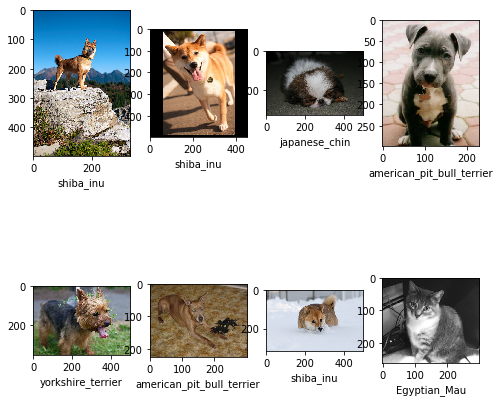

In [9]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

__SAGEMAKER__

In [10]:
role = sagemaker.get_execution_role()
bucket_name = 'sage-imagespets'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1


In [11]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

__Prepare Data for Sagemaker__

In [12]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [13]:
prepare_data(train_annotations, 'train')

100%|██████████| 5883/5883 [00:01<00:00, 4232.20it/s]


In [14]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1466/1466 [00:00<00:00, 4278.64it/s]


In [15]:

sess = sagemaker.Session()
s3_train_path = sess.upload_data(path='train',bucket=bucket_name, 
                                 key_prefix='train')
print(1)
s3_train_lst_path = sess.upload_data(path='train_lst',bucket=bucket_name, 
                                     key_prefix='train_lst')
print(2)
s3_validation_path = sess.upload_data(path='validation',bucket=bucket_name,
                                      key_prefix='validation')
print(3)
s3_validation_lst_path = sess.upload_data(path='validation_lst',
                                          bucket=bucket_name, key_prefix='validation_lst')
print(4)


1
2
3
4


In [16]:
s3_validation_lst_path

's3://sage-imagespets/validation_lst'

__SAGEMAKER MODEL__

In [22]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://sage-imagespets/output',
    sagemaker_session=sess)

__SET HYPERPARAMETERS__

In [24]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    use_weighted_loss=1,
    augmentation_type='crop_color_transform',
)

__DATA CHANNELS__

In [25]:

train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')

train_lst_data = sagemaker.inputs.TrainingInput(s3_train_lst_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.inputs.TrainingInput(s3_validation_lst_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')

In [26]:
data_channels = {
    'train':train_data,
    'train_lst':train_lst_data,
    'validation':validation_data,
    'validation_lst':validation_lst_data
    
}

__MODEL TRAINING__

In [27]:
model.fit(inputs=data_channels, logs=True)

2021-01-18 15:26:24 Starting - Starting the training job...
2021-01-18 15:26:48 Starting - Launching requested ML instancesProfilerReport-1610983584: InProgress
......
2021-01-18 15:27:48 Starting - Preparing the instances for training.........
2021-01-18 15:29:26 Downloading - Downloading input data.........
2021-01-18 15:30:51 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[01/18/2021 15:31:11 INFO 140450990688064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[01/18/2021 15:31:11 INFO 140450990688064] Merging with provided configuration from /opt/

In [28]:
deployed_model = model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')
print('\nModel Deployed')

-----------------!
Model Deployed


In [32]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']



In [33]:
index = 2

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b, initial_args={"ContentType": "image/jpeg"})
results = json.loads(results)

print(results)

[3.83583875773752e-09, 1.4178543779053143e-06, 3.042472940251173e-08, 6.018672706886719e-07, 1.6588597873123945e-07, 1.535448018730179e-10, 1.5606933629896957e-06, 1.0015186457934533e-09, 9.997423831009655e-07, 9.926511665980797e-07, 2.0726899307987878e-08, 1.6991882345607223e-09, 1.4621658550595384e-08, 1.5203001357821933e-10, 1.0533172556392856e-08, 3.2232199487225444e-07, 4.642605927074328e-05, 1.8320509553859665e-08, 9.845951831621846e-10, 1.3743763815909915e-07, 1.2298287388468054e-11, 5.144492609687745e-10, 9.045301396781724e-08, 1.290574591639171e-10, 5.470404289553699e-07, 4.426552280278884e-08, 3.0024219221935766e-10, 0.9999256134033203, 1.88816695612104e-08, 2.0092908016522415e-05, 1.0775851677635728e-07, 1.5266022046489525e-07, 2.548178557049141e-08, 1.1582584846792088e-07, 5.016460704609926e-07, 2.05215204829301e-08, 1.7680661379415596e-09]


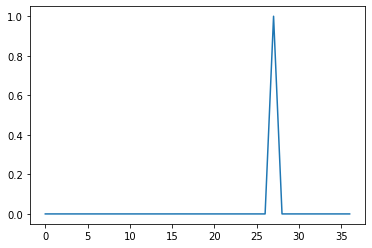

In [34]:
plt.plot(range(37), results);

In [35]:
classes[np.argmax(results)]

'Siamese'

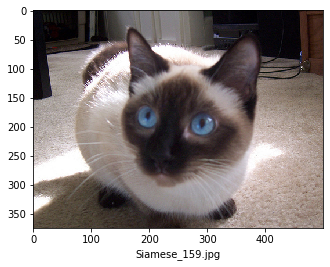

In [36]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()